In [ ]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob


In [ ]:
df = pd.read_csv("cleaned_reviews.csv")

df['sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))

feature_columns = ['monthly_sales', 'complaints_count', 'avg_rating', 'staff_turnover', 'review_length', 'sentiment']
X = df[feature_columns]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_columns)


In [ ]:
model = joblib.load("restaurant_risk_xgb.pkl")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)


--- Restaurant ID: 65 ---
Predicted Risk: High Risk ⚠️

Top 3 Features Driving Prediction:
1. avg_rating
2. complaints_count
3. monthly_sales

SHAP Force Plot for the first review of this restaurant:


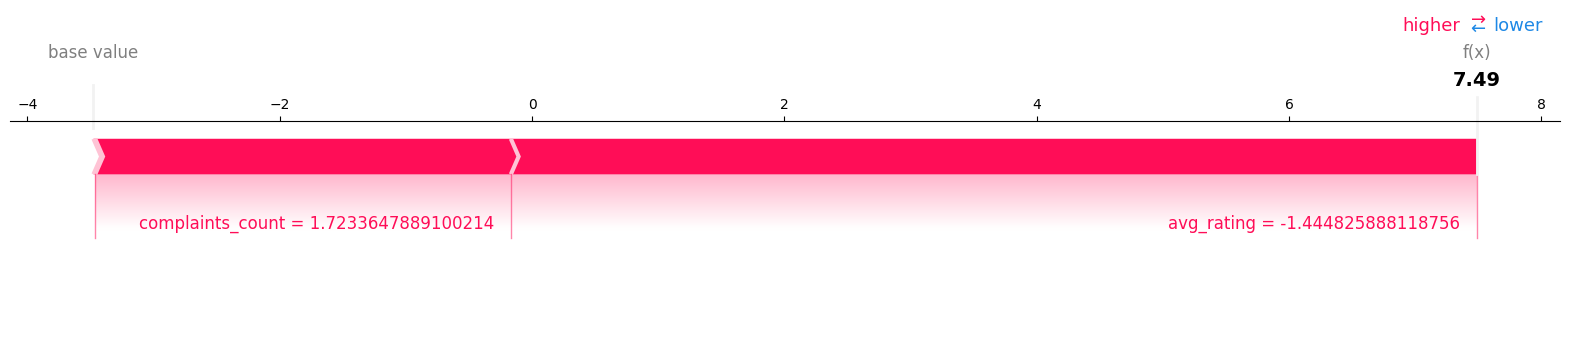

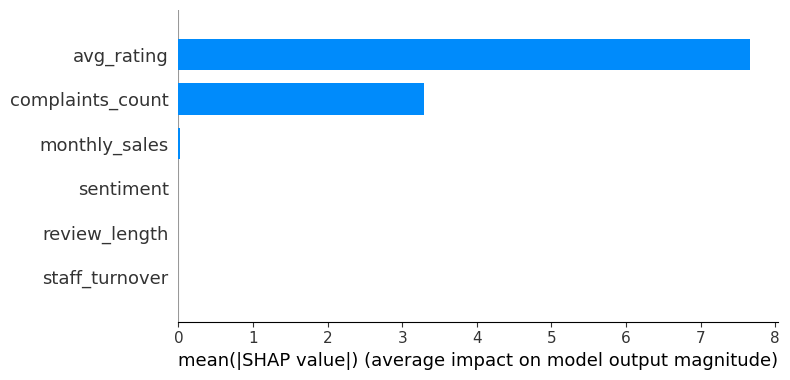

--- Restaurant ID: 6 ---
Predicted Risk: Low Risk ✅

Top 3 Features Driving Prediction:
1. avg_rating
2. complaints_count
3. monthly_sales

SHAP Force Plot for the first review of this restaurant:


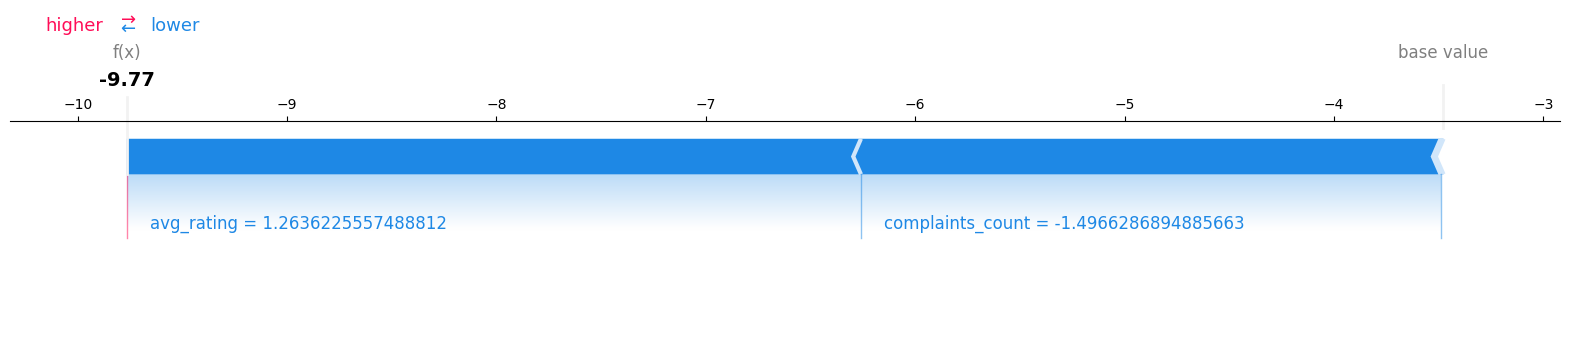

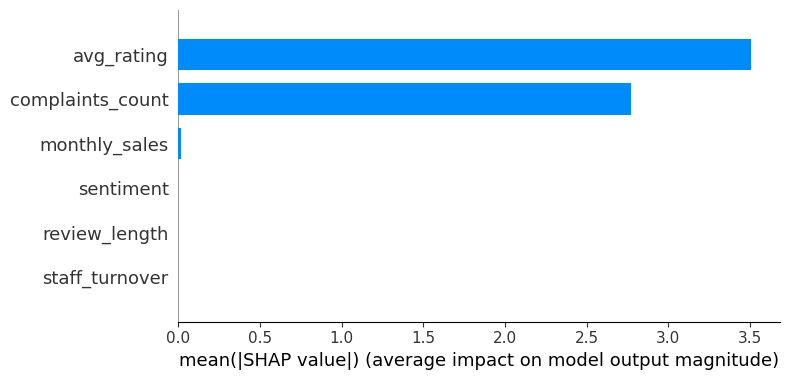

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

restaurant_ids = [65, 6]

for selected_id in restaurant_ids:
    print(f"--- Restaurant ID: {selected_id} ---")

    restaurant_data = df[df['restaurant_id'] == selected_id]
    X_restaurant = X_scaled.loc[restaurant_data.index]


    prediction = model.predict(X_restaurant)[0]
    risk = "High Risk ⚠️" if prediction == 1 else "Low Risk ✅"
    print(f"Predicted Risk: {risk}\n")


    shap_vals_restaurant = shap_values[restaurant_data.index, :]

    mean_shap = np.abs(shap_vals_restaurant).mean(axis=0)
    feature_array = np.array(feature_columns)
    top_indices = mean_shap.argsort()[-3:][::-1]
    top_features = feature_array[top_indices]

    print("Top 3 Features Driving Prediction:")
    for i, feat in enumerate(top_features, 1):
        print(f"{i}. {feat}")

    print("\nSHAP Force Plot for the first review of this restaurant:")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_vals_restaurant[0,:], X_restaurant.iloc[0,:], matplotlib=True)


    plt.figure(figsize=(6,4))
    shap.summary_plot(shap_vals_restaurant, X_restaurant, plot_type="bar", show=True)
